# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

c:\Users\Полина\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [17]:
recommender = MainRecommender(data_train_lvl_1, weighting='bm25')

100%|██████████| 5001/5001 [00:00<00:00, 23322.78it/s]


In [18]:
recommender.get_als_recommendations(2375, N=5)

[992622, 934399, 924667, 869465, 932462]

In [19]:
recommender.get_own_recommendations(2375, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

In [20]:
recommender.get_similar_items_recommendation(2375, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

In [21]:
recommender.get_similar_users_recommendation(2375, N=5)

[1029743, 1029743, 1106523, 5569230, 916122]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [22]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [23]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
# Т.е. только для юзеров, кто был на этапе -- давние покупки --, но на -- 6 недель -- могли появиться новые (они не попали в обучение ALS).
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

In [24]:
users_lvl_2['candidates_own_recommendations'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [25]:
users_lvl_2['candidates_similar_items_recommendation'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))

In [26]:
users_lvl_2['candidates_similar_users_recommendation'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [27]:
users_lvl_2['candidates_als_recommendations'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))

In [28]:
result_lvl_1_to_check = pd.merge(result_lvl_1, users_lvl_2, how='inner', on="user_id")
result_lvl_1_to_check.head(2)

,user_id,actual,candidates_own_recommendations,candidates_similar_items_recommendation,candidates_similar_users_recommendation,candidates_als_recommendations
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1029743, 1106523, 5569230, 916122, 8...","[965555, 852856, 930666, 940770, 839605, 99188..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1029743, 1106523, 5569230, 916122, 8...","[851819, 1023196, 1001827, 969725, 877391, 898..."


In [29]:
for variant in result_lvl_1_to_check.columns[2:6]:
    print(f"{variant}: {result_lvl_1_to_check.apply(lambda row: recall_at_k(row[variant], row['actual'], k=50), axis=1).mean()}")

candidates_own_recommendations: 0.055431256385437847
candidates_similar_items_recommendation: 0.0432368435310526
candidates_similar_users_recommendation: 0.0484636758085872
candidates_als_recommendations: 0.003211835638454089


Own_recomendations даёт лучший результат по recall@50, видимо это связано с частыми повторными покупками. Такой бейзлайн лучше не использовать, так как он не привнесет никакой вариативности для клиента и не стимулирует новый опыт.

In [30]:
k_values = [5, 20, 50, 100, 200, 500]
for value in k_values:
    result_lvl_1_to_check[f'candidates_sim_users_k_{value}'] = result_lvl_1_to_check['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=value))

In [31]:
i=0
recall_values = []
for variant in result_lvl_1_to_check.columns[6:]:
    res = result_lvl_1_to_check.apply(lambda row: recall_at_k(row[variant], row['actual'], k=k_values[i]), axis=1).mean()
    print(f"{variant}: {res}")
    recall_values.append(res)
    i += 1

candidates_sim_users_k_5: 0.01942875227645647
candidates_sim_users_k_20: 0.03539330319648796
candidates_sim_users_k_50: 0.0484636758085872
candidates_sim_users_k_100: 0.06726412270832458
candidates_sim_users_k_200: 0.09501216975107392
candidates_sim_users_k_500: 0.13755232913065274


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


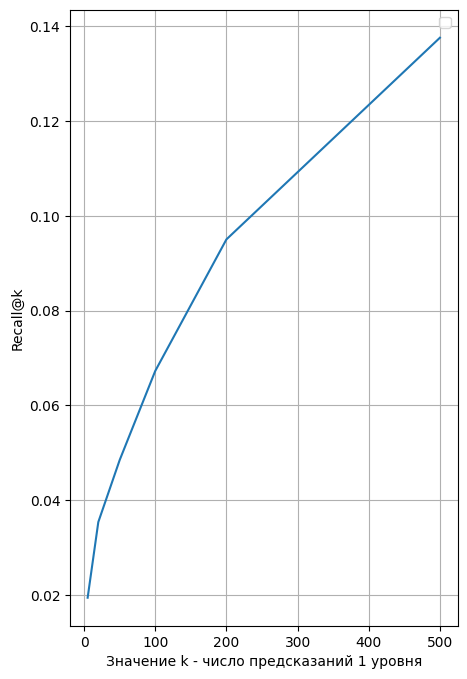

In [32]:
plt.rcParams['figure.figsize'] = 5, 8

plt.plot(k_values, recall_values)

plt.xlabel('Значение k - число предсказаний 1 уровня')
plt.ylabel('Recall@k')

plt.legend()
plt.grid()

plt.show()

Recall@k растет при росте k, это следует из того, что чем больше мы охватываем позиций, тем больше шанс "зацепить" в выборку покупки юзера. Если следовать эмпирическому "правилу локтя", то хороший выбор будет взять k=200. В этой точке происходит самый крутой излом графика.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [40]:
df = pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates_similar_users_recommendation[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates_similar_users_recommendation.values)})

df.head(4)

,user_id,item_id
0,2070,1029743
1,2070,1029743
2,2070,1106523
3,2070,5569230


In [41]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')  # Получается таргеты будут заполнены только там, где были истинные покупки, а в остальные строки merge поставит None

targets_lvl_2['target'].fillna(0, inplace= True)  # Обработаем эти None (см. ниже результат в таблице)

In [42]:
targets_lvl_2['target'].value_counts()

0.0    101912
1.0      8827
Name: target, dtype: int64

In [43]:
targets_lvl_2['target'].mean()

0.07970994861792143

In [45]:
targets_lvl_2.head(10)  # Получилось напротив каждой пары user-item стоит 0 или 1 (Y)
# Но нужно ещё добавить фичи (X)

,user_id,item_id,target
0,2070,1029743,0.0
1,2070,1029743,0.0
2,2070,1106523,0.0
3,2070,5569230,0.0
4,2070,916122,1.0
5,2070,844179,0.0
6,2070,1044078,0.0
7,2070,1126899,0.0
8,2070,1070820,0.0
9,2070,1127831,0.0


In [46]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [47]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [48]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


Фичи user_id:
- Средний чек
- Средняя сумма покупки 1 товара в каждой категории
- Кол-во покупок в каждой категории
- Частотность покупок раз в месяц
- Долю покупок в выходные
- Долю покупок утром, днем, вечером

Фичи item_id:
- Кол-во покупок в неделю
- Среднее ол-во покупок 1 товара в категории в неделю
- Кол-во покупок в неделю / Среднее кол-во покупок 1 товара в категории в неделю
- Цена (Можно посчитать из retil_train.csv)
- Цена / Средняя цена товара в категории

Фичи пары user_id - item_id (кстати, могли бы быть и весами в нашем ALS!)
- Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - Цена item_id
- Кол-во покупок юзером конкретной категории в неделю - Среднее кол-во покупок всеми юзерами конкретной категории в неделю
- Кол-во покупок юзером конкретной категории в неделю / Среднее кол-во покупок всеми юзерами конкретной категории в неделю

In [49]:
data_merged = pd.merge(data, item_features[['item_id', 'department', 'commodity_desc']], how='left', on="item_id")
data_merged = pd.merge(data_merged, user_features, how='left', on="user_id")
data_merged.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,coupon_match_disc,department,commodity_desc,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,...,0.0,PRODUCE,POTATOES,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,...,0.0,PRODUCE,ONIONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,...,0.0,PRODUCE,VEGETABLES - ALL OTHERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,...,0.0,PRODUCE,TROPICAL FRUIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,...,0.0,PRODUCE,ORGANICS FRUIT & VEGETABLES,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Цена / Средняя цена товара в категории

In [50]:
mean_sales_value_in_department = data_merged.groupby(['department'], as_index=False).agg({'sales_value':'mean'})\
                       .rename(columns={'sales_value':'mean_sales_value_in_department'})
data_merged = data_merged.merge(mean_sales_value_in_department, on='department', how='left')
mean_sales_value_in_department.head(3)

,department,mean_sales_value_in_department
0,,0.000000
1,AUTOMOTIVE,7.381186
2,CHARITABLE CONT,3.870000


In [51]:
data_merged['item_value_div_mean_sales_value_in_department'] = data_merged['sales_value'] / data_merged['mean_sales_value_in_department']
average_item_value_div_mean_sales_value_in_department = data_merged[['item_value_div_mean_sales_value_in_department', 'user_id', 'item_id']].groupby(['user_id', 'item_id'], as_index=False).agg({'item_value_div_mean_sales_value_in_department':'mean'})

In [52]:
targets_lvl_2 = targets_lvl_2.merge(average_item_value_div_mean_sales_value_in_department, on=['user_id', 'item_id'], how='left')
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.383269
1,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.383269
2,2070,1106523,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.971265


Кол-во покупок в неделю

In [53]:
purchases_count_in_week = data_merged.groupby(['item_id', 'week_no'], as_index=False).agg({'sales_value':'count'})\
                       .rename(columns={'sales_value':'purchases_count_in_week'})
purchases_count_in_week.head()

,item_id,week_no,purchases_count_in_week
0,25671,23,1
1,25671,36,1
2,25671,59,1
3,26081,36,1
4,26093,66,1


In [54]:
mean_purchases_count_in_week = purchases_count_in_week.groupby(['item_id'], as_index=False).agg({'purchases_count_in_week':'mean'})\
                       .rename(columns={'purchases_count_in_week':'mean_purchases_count_in_week'})
mean_purchases_count_in_week.sort_values(['mean_purchases_count_in_week'],ascending=False).head()

,item_id,mean_purchases_count_in_week
35054,1082185,288.021053
56233,6534178,195.361702
29195,1029743,141.631579
25333,995242,119.968421
37719,1106523,96.578947


In [55]:
targets_lvl_2 = targets_lvl_2.merge(mean_purchases_count_in_week, on='item_id', how='left')
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.383269,141.631579
1,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.383269,141.631579
2,2070,1106523,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.971265,96.578947


Частотность покупок раз в месяц

In [56]:
sales_value_on_week = data_merged.groupby(['user_id', 'week_no'], as_index=False).agg({'sales_value':'sum'})\
                       .rename(columns={'sales_value':'sales_value_on_week'})
sales_value_on_week.head()

,user_id,week_no,sales_value_on_week
0,1,8,78.66
1,1,10,41.10
2,1,13,26.90
3,1,14,63.43
4,1,15,53.45


In [57]:
len(data_merged.week_no.unique())  # Всего недель

95

In [58]:
week_quantity_on_user = sales_value_on_week.groupby(['user_id'], as_index=False).agg({'week_no':'count'})\
                       .rename(columns={'week_no':'week_quantity_on_user'})
week_quantity_on_user.head()

,user_id,week_quantity_on_user
0,1,64
1,2,34
2,3,35
3,4,26
4,5,25


In [59]:
week_quantity_on_user['purchases_frequency_in_a_month'] = week_quantity_on_user['week_quantity_on_user'] / len(data_merged.week_no.unique()) * 4
week_quantity_on_user.head()

,user_id,week_quantity_on_user,purchases_frequency_in_a_month
0,1,64,2.694737
1,2,34,1.431579
2,3,35,1.473684
3,4,26,1.094737
4,5,25,1.052632


In [60]:
targets_lvl_2 = targets_lvl_2.merge(week_quantity_on_user[['user_id', 'purchases_frequency_in_a_month']], on='user_id', how='left')
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.383269,141.631579,3.452632
1,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.383269,141.631579,3.452632
2,2070,1106523,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.971265,96.578947,3.452632


Средний чек

In [61]:
sales_value_on_basket = data_merged.groupby(['user_id', 'basket_id'], as_index=False).agg({'sales_value':'sum'})\
                       .rename(columns={'sales_value':'sales_value_on_basket'})
sales_value_on_basket.head()

,user_id,basket_id,sales_value_on_basket
0,1,27601281299,78.66
1,1,27774192959,41.10
2,1,28024266849,26.90
3,1,28106322445,63.43
4,1,28235481967,53.45


In [62]:
average_check = sales_value_on_basket.groupby(['user_id'], as_index=False).agg({'sales_value_on_basket':'mean'})\
                       .rename(columns={'sales_value_on_basket':'average_check'})
average_check.head()

,user_id,average_check
0,1,50.125443
1,2,41.442045
2,3,57.651111
3,4,40.003667
4,5,19.712895


In [63]:
targets_lvl_2 = targets_lvl_2.merge(average_check, on='user_id', how='left')
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month,average_check
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.383269,141.631579,3.452632,12.92937
1,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.383269,141.631579,3.452632,12.92937
2,2070,1106523,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.971265,96.578947,3.452632,12.92937


Кол-во покупок юзером конкретной категории в неделю / Среднее кол-во покупок всеми юзерами конкретной категории в неделю

In [64]:
purchases_in_dept_by_user = data_merged.groupby(['user_id', 'department'], as_index=False).agg({'sales_value':'count'})\
                       .rename(columns={'sales_value':'purchases_in_dept_by_user'})
purchases_in_dept_by_user.head()

,user_id,department,purchases_in_dept_by_user
0,1,,12
1,1,DELI,58
2,1,DRUG GM,149
3,1,FLORAL,1
4,1,GROCERY,1064


In [65]:
week_count = data_merged.groupby(['user_id'], as_index=False)['week_no'].nunique().rename(columns={'week_no':'week_count'})
week_count.head()

,user_id,week_count
0,1,64
1,2,34
2,3,35
3,4,26
4,5,25


In [66]:
purchases_in_dept_by_user_in_week = purchases_in_dept_by_user.merge(week_count, how='left', on="user_id")
purchases_in_dept_by_user_in_week['purchases_in_dept_by_user_in_week'] = purchases_in_dept_by_user_in_week['purchases_in_dept_by_user'] / purchases_in_dept_by_user_in_week['week_count']
purchases_in_dept_by_user_in_week.head()

,user_id,department,purchases_in_dept_by_user,week_count,purchases_in_dept_by_user_in_week
0,1,,12,64,0.187500
1,1,DELI,58,64,0.906250
2,1,DRUG GM,149,64,2.328125
3,1,FLORAL,1,64,0.015625
4,1,GROCERY,1064,64,16.625000


In [67]:
purchases_in_dept_all = data_merged.groupby(['department'], as_index=False).agg({'sales_value':'count'})\
                       .rename(columns={'sales_value':'purchases_in_dept_all'})
purchases_in_dept_all['purchases_in_dept_all_in_week'] = purchases_in_dept_all['purchases_in_dept_all'] / len(data_merged.week_no.unique())
purchases_in_dept_all.head()

,department,purchases_in_dept_all,purchases_in_dept_all_in_week
0,,7210,75.894737
1,AUTOMOTIVE,59,0.621053
2,CHARITABLE CONT,2,0.021053
3,CHEF SHOPPE,661,6.957895
4,CNTRL/STORE SUP,21,0.221053


In [68]:
relatively_purchases_in_dept_by_user = purchases_in_dept_by_user_in_week.merge(purchases_in_dept_all, on='department')
relatively_purchases_in_dept_by_user['relatively_purchases_in_dept_by_user'] = relatively_purchases_in_dept_by_user['purchases_in_dept_by_user_in_week'] / relatively_purchases_in_dept_by_user['purchases_in_dept_all_in_week']

In [69]:
targets_lvl_2 = targets_lvl_2.merge(relatively_purchases_in_dept_by_user[['user_id', 'department','relatively_purchases_in_dept_by_user']], on=['user_id', 'department'], how='left')
targets_lvl_2.tail()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month,average_check,relatively_purchases_in_dept_by_user
110734,1745,857503,0.0,69,PRODUCE,Private,CARROTS,CARROTS MINI PEELED,2 LB,45-54,...,Under 15K,Unknown,Single Male,2,None/Unknown,NaN,11.515789,2.905263,20.311933,0.000404
110735,1745,1122358,0.0,69,GROCERY,Private,REFRGRATD JUICES/DRNKS,DAIRY CASE 100% PURE JUICE - O,1 GA,45-54,...,Under 15K,Unknown,Single Male,2,None/Unknown,NaN,12.659574,2.905263,20.311933,0.000585
110736,1745,1132771,0.0,3787,DELI,National,CHEESES,CHEESE: NATURAL BULK,,45-54,...,Under 15K,Unknown,Single Male,2,None/Unknown,NaN,11.105263,2.905263,20.311933,0.000213
110737,1745,823704,0.0,2082,MEAT-PCKGD,National,BREAKFAST SAUSAGE/SANDWICHES,ROLLS - PORK,16 OZ,45-54,...,Under 15K,Unknown,Single Male,2,None/Unknown,NaN,9.943820,2.905263,20.311933,0.001088
110738,1745,854405,0.0,397,MEAT-PCKGD,National,MEAT - MISC,BREAST - BONELESS(IQF),40 OZ,45-54,...,Under 15K,Unknown,Single Male,2,None/Unknown,NaN,9.638298,2.905263,20.311933,0.001088


Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - Цена item_id (пара item-user)

In [70]:
mean_sales_value_in_dept = data_merged.groupby(['department'], as_index=False).agg({'sales_value':'mean'})\
                       .rename(columns={'sales_value':'mean_sales_value_in_dept'})
mean_sales_value_in_dept.head()

,department,mean_sales_value_in_dept
0,,0.000000
1,AUTOMOTIVE,7.381186
2,CHARITABLE CONT,3.870000
3,CHEF SHOPPE,2.915234
4,CNTRL/STORE SUP,2.335714


In [71]:
data_merged = data_merged.merge(mean_sales_value_in_dept, on='department', how='left')
data_merged['mean_sales_value_in_dept_subtract_sales_value'] = data_merged['mean_sales_value_in_dept'] - data_merged['sales_value']

In [72]:
mean_sales_value_in_dept_subtract_sales_value = data_merged[['user_id', 'item_id', 'mean_sales_value_in_dept_subtract_sales_value']].groupby(['user_id', 'item_id'], as_index=False).agg({'mean_sales_value_in_dept_subtract_sales_value':'mean'})

In [73]:
mean_sales_value_in_dept_subtract_sales_value = data_merged[['user_id', 'item_id', 'mean_sales_value_in_dept_subtract_sales_value']].groupby(['user_id', 'item_id'], as_index=False).agg({'mean_sales_value_in_dept_subtract_sales_value':'mean'})

Проверка

In [74]:
targets_lvl_2['target'].shape

(110739,)

In [75]:
targets_lvl_2['target'].mean()

0.07970994861792143

__Обучение__

In [76]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [80]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110739 entries, 0 to 110738
Data columns (total 20 columns):
 #   Column                                         Non-Null Count   Dtype   
---  ------                                         --------------   -----   
 0   user_id                                        110739 non-null  int64   
 1   item_id                                        110739 non-null  int32   
 2   manufacturer                                   110739 non-null  category
 3   department                                     110739 non-null  category
 4   brand                                          110739 non-null  category
 5   commodity_desc                                 110739 non-null  category
 6   sub_commodity_desc                             110739 non-null  category
 7   curr_size_of_product                           110739 non-null  category
 8   age_desc                                       41597 non-null   category
 9   marital_status_code       

In [81]:
cat_feats = X_train.columns[2:-5].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [78]:
y_train.mean()

target    0.07971
dtype: float64

In [82]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

c:\Users\Полина\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Полина\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\Полина\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [83]:
lgb.classes_

array([0., 1.])

In [84]:
train_preds[:, 1]  # Вероятности покупки

array([7.58134079e-01, 7.58134079e-01, 6.67100481e-01, ...,
       1.55966327e-05, 1.36323485e-05, 1.36683307e-05])

In [87]:
target_probas = pd.DataFrame(data=train_preds[:, 1], columns=['target_probas'])
target_probas.head()

,target_probas
0,0.758134
1,0.758134
2,0.667100
3,0.048308
4,0.465354


In [88]:
targets_lvl_2_probas = pd.concat([targets_lvl_2, target_probas], axis=1)
targets_lvl_2_probas.sort_values(['user_id', 'target_probas'],ascending=False)[targets_lvl_2_probas['user_id'] == 1100].head()

C:\Users\Полина\AppData\Local\Temp\ipykernel_13816\1976381697.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  targets_lvl_2_probas.sort_values(['user_id', 'target_probas'],ascending=False)[targets_lvl_2_probas['user_id'] == 1100].head()


,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month,average_check,relatively_purchases_in_dept_by_user,target_probas
93686,1100,857503,0.0,69,PRODUCE,Private,CARROTS,CARROTS MINI PEELED,2 LB,NaN,...,NaN,NaN,NaN,NaN,NaN,11.515789,0.8,12.351739,0.000042,0.000045
93658,1100,899624,0.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,NaN,...,NaN,NaN,NaN,NaN,NaN,27.452381,0.8,12.351739,0.000042,0.000042
93687,1100,1122358,0.0,69,GROCERY,Private,REFRGRATD JUICES/DRNKS,DAIRY CASE 100% PURE JUICE - O,1 GA,NaN,...,NaN,NaN,NaN,NaN,NaN,12.659574,0.8,12.351739,0.000095,0.000038
93657,1100,854852,0.0,2,PRODUCE,National,TOMATOES,TOMATOES HOTHOUSE ON THE VINE,13 LB,NaN,...,NaN,NaN,NaN,NaN,NaN,41.463158,0.8,12.351739,0.000042,0.000023
93662,1100,1081177,0.0,2,PRODUCE,National,TOMATOES,TOMATOES VINE RIPE BULK,15 LB,NaN,...,NaN,NaN,NaN,NaN,NaN,33.840426,0.8,12.351739,0.000042,0.000019


__Подготовим data_val_lvl_2__

In [89]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [90]:
targets_lvl_2_probas.duplicated(subset=['user_id', 'item_id']).sum()  # Выше были дубликаты пар user_id-item_id, нужно их обработать

5340

In [91]:
targets_lvl_2_probas = targets_lvl_2_probas.drop_duplicates(subset=['user_id', 'item_id'])

In [92]:
top_5_lvl_2_boosting = targets_lvl_2_probas.sort_values('target_probas', ascending=False).groupby('user_id').head(5)
top_5_lvl_2_boosting.head(8)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month,average_check,relatively_purchases_in_dept_by_user,target_probas
35194,1489,1029743,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,...,NaN,NaN,NaN,NaN,1.511860,141.631579,3.536842,31.686647,0.002793,0.932437
36972,1527,1029743,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,25-34,...,Homeowner,2 Adults No Kids,2,None/Unknown,1.463694,141.631579,3.789474,53.839793,0.001418,0.929764
5942,2252,1029743,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,Homeowner,2 Adults Kids,4,2,1.281730,141.631579,3.578947,28.562987,0.001426,0.923046
34766,707,1029743,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,25-34,...,Homeowner,2 Adults Kids,5+,3+,1.587715,141.631579,3.326316,39.198419,0.001946,0.921004
3228,1804,1029743,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,65+,...,Homeowner,2 Adults No Kids,2,None/Unknown,1.393892,141.631579,3.368421,32.699577,0.001026,0.914002
18191,1778,1029743,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,25-34,...,Homeowner,2 Adults No Kids,2,None/Unknown,1.408990,141.631579,3.452632,35.276480,0.001226,0.912245
33978,2317,1029743,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,35-44,...,Homeowner,2 Adults Kids,5+,3+,1.529787,141.631579,3.242105,91.329859,0.002524,0.910262
10352,2459,1029743,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,...,NaN,NaN,NaN,NaN,1.130493,141.631579,3.747368,21.057988,0.003065,0.910005


In [93]:
all_users_list = top_5_lvl_2_boosting['user_id'].drop_duplicates().to_list()
recs = []
for user in all_users_list:
    recs_user = []
    recs_user.append(user)
    recs_user.append(top_5_lvl_2_boosting.loc[top_5_lvl_2_boosting['user_id'] == user, 'item_id'].tolist())
    recs.append(recs_user)
    
top_5_lvl_2_boosting_recs = pd.DataFrame(recs, columns=['user_id', 'top_5_lvl_2_boosting_recs'])
top_5_lvl_2_boosting_recs

,user_id,top_5_lvl_2_boosting_recs
0,1489,"[1029743, 983584, 5569230, 1132771, 8090537]"
1,1527,"[1029743, 1106523, 1070820, 5569230, 866211]"
2,2252,"[1029743, 1106523, 1070820, 916122, 899624]"
3,707,"[1029743, 1106523, 1044078, 1075368, 5569471]"
4,1804,"[1029743, 866211, 1004906, 901062, 5569230]"
...,...,...
2146,2120,"[1122358, 8090537, 1105488, 5569845, 878996]"
2147,729,"[1122358, 834117, 986912, 999858, 913210]"
2148,1675,"[1122358, 933835, 916122, 1081177, 878996]"
2149,954,"[1122358, 1105488, 878996, 1081177, 933835]"


In [94]:
result_lvl_2 = pd.merge(result_lvl_2, top_5_lvl_2_boosting_recs, how='inner', on="user_id")
result_lvl_2.head(2)

,user_id,actual,top_5_lvl_2_boosting_recs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1029743, 940947, 1004906, 901062, 6034857]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[901062, 1029743, 866211, 6034857, 844179]"


In [95]:
result_lvl_2['top_5_lvl_2_sim_users_recommendations'] = result_lvl_2['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=5))
result_lvl_2.head(2)

,user_id,actual,top_5_lvl_2_boosting_recs,top_5_lvl_2_sim_users_recommendations
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1029743, 940947, 1004906, 901062, 6034857]","[1029743, 1029743, 1106523, 5569230, 916122]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[901062, 1029743, 866211, 6034857, 844179]","[1029743, 1029743, 1106523, 5569230, 916122]"


__Сравнение моделей__

In [96]:
for variant in result_lvl_2.columns[2:]:
    print(f"{variant}: {result_lvl_2.apply(lambda row: precision_at_k(row[variant], row['actual'], k=5), axis=1).mean()}")

top_5_lvl_2_boosting_recs: 0.22443864229765018
top_5_lvl_2_sim_users_recommendations: 0.1460052219321149


Видим, что Бустинг значительно улучшил качество рекомендаций по метрике precision@k.

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 